# Simple Linear Regression Implementation and Comparison

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm, trange

# Load the California housing dataset
housing = pd.read_csv('housing.csv')

# Display the first few rows of the dataset
print("Dataset Preview:")
housing.head()

Dataset Preview:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [22]:
# Drop categorical data
housing.drop(["ocean_proximity"], axis=1, inplace=True)

# Display columns after processing
print("Dataset columns:")
print(housing.columns.tolist())

Dataset columns:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


In [23]:
# Custom Simple Linear Regression Implementation

class SimpleLinearRegression:
    
    def __init__(self, learning_rate=0.01, iterations=1000, tol=1e-5):
        self.intercept_ = None  # beta_0
        self.coef_ = None      # beta_1
        self.feature_name = None
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.tol = tol
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        
        # Convert to numpy arrays if they're DataFrames
        if isinstance(X, pd.DataFrame):
            self.feature_name = X.columns[0]
            X = X.values
        else:
            self.feature_name = 'feature'
            
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        
        # Ensure X is 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        # Number of samples
        n = X.shape[0]
        X_flat = X.flatten()
        
        # Initialize parameters
        self.intercept_ = 0
        self.coef_ = np.array([0.0])
        
        # Gradient Descent
        prev_cost = float('inf')
        for i in trange(self.iterations):
            # Predictions
            y_pred = self.intercept_ + self.coef_[0] * X_flat
            
            # Calculate error
            error = y - y_pred
            
            # Compute gradients (with safeguards for numeric stability)
            d_intercept = (-2/n) * np.sum(error)
            d_coef = (-2/n) * np.sum(X_flat * error)
            
            # Check for overflow/underflow
            if not np.isfinite(d_intercept) or not np.isfinite(d_coef):
                print("Warning: Gradient overflow detected. Stopping early.")
                break
                
            # Update parameters with gradient clipping for stability
            grad_clip_threshold = 1e10
            d_intercept = np.clip(d_intercept, -grad_clip_threshold, grad_clip_threshold)
            d_coef = np.clip(d_coef, -grad_clip_threshold, grad_clip_threshold)
            
            self.intercept_ = self.intercept_ - self.learning_rate * d_intercept
            self.coef_[0] = self.coef_[0] - self.learning_rate * d_coef
            
            # Calculate cost (mean squared error) with safeguards
            # Use a more numerically stable method to calculate MSE
            cost = np.mean(error**2)
            
            # Check for cost validity
            if not np.isfinite(cost):
                print("Warning: Cost overflow detected. Stopping early.")
                break
                
            # Check for convergence
            if prev_cost != float('inf') and abs(prev_cost - cost) < self.tol:
                print(f"Converged after {i} iterations")
                break
                
            prev_cost = cost
            
            # Early stopping if parameters are exploding
            if not np.isfinite(self.intercept_) or not np.isfinite(self.coef_[0]):
                print("Warning: Parameter overflow detected. Stopping early.")
                # Reset to previous stable values (could be improved)
                self.intercept_ = 0
                self.coef_ = np.array([0.0])
                break
        
        return self
    
    def predict(self, X):
        
        if self.intercept_ is None or self.coef_ is None:
            raise Exception("Model not fitted yet. Call 'fit' before using 'predict'.")
        
        # Convert to numpy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Ensure X is 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        # Calculate predictions
        return self.intercept_ + self.coef_[0] * X.flatten()  # Flatten X for dot product

In [24]:
# Define a function that handles fitting, comparison and plotting for a given feature
def analyze_simple_linear_regression(feature_name):
    # Prepare data
    X = housing[[feature_name]].copy()
    y = housing['median_house_value'].copy()
    
    # Normalize X to prevent overflow issues
    X_mean = X.mean().values[0]
    X_std = X.std().values[0]
    X_normalized = (X - X_mean) / X_std
    
    # Custom implementation
    print(f"\n=== Analysis for feature: '{feature_name}' ===")
    print(f"Feature stats - Mean: {X_mean:.2f}, Std: {X_std:.2f}")
    print("\nFitting custom model on normalized data...")
    slr = SimpleLinearRegression(learning_rate=0.01, iterations=10000)
    slr.fit(X_normalized, y)
    
    # Denormalize the coefficient to match original scale
    original_coef = slr.coef_[0] / X_std
    original_intercept = slr.intercept_ - slr.coef_[0] * (X_mean / X_std)
    
    # Sklearn implementation (works fine with non-normalized data)
    print("Fitting sklearn model...")
    sklearn_slr = LinearRegression()
    sklearn_slr.fit(X, y)
    
    # Print and compare results
    print(f"\nCustom Implementation Results (denormalized):")
    print(f"Intercept (beta_0): {original_intercept:.4f}")
    print(f"Coefficient (beta_1): {original_coef:.4f}")
    
    print(f"\nSklearn Implementation Results:")
    print(f"Intercept (beta_0): {sklearn_slr.intercept_:.4f}")
    print(f"Coefficient (beta_1): {sklearn_slr.coef_[0]:.4f}")
    
    print("\nComparison of both implementations:")
    print(f"{'Parameter':<20} {'Custom':<15} {'Sklearn':<15} {'Difference':<15}")
    print("-" * 65)
    print(f"{'Intercept (beta_0)':<20} {original_intercept:<15.4f} {sklearn_slr.intercept_:<15.4f} {abs(original_intercept - sklearn_slr.intercept_):<15.8f}")
    print(f"{'Coefficient (beta_1)':<20} {original_coef:<15.4f} {sklearn_slr.coef_[0]:<15.4f} {abs(original_coef - sklearn_slr.coef_[0]):<15.8f}")
    
    # Visualize the regression line
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of the data
    plt.scatter(X, y, alpha=0.5, label='Data points')
    
    # Set up the x values for the regression line
    x_min = X.values.min()
    x_max = X.values.max()
    x_line = np.array([x_min, x_max])
    
    # Custom implementation regression line (using denormalized coefficients)
    y_line_custom = original_intercept + original_coef * x_line
    plt.plot(x_line, y_line_custom, color='red', linewidth=2, label='Custom regression line')
    
    # Sklearn implementation regression line
    y_line_sklearn = sklearn_slr.intercept_ + sklearn_slr.coef_[0] * x_line
    plt.plot(x_line, y_line_sklearn, color='blue', linewidth=2, linestyle='--', label='Sklearn regression line')
    
    # Add labels and title
    plt.xlabel(feature_name)
    plt.ylabel('median_house_value')
    plt.title(f'Simple Linear Regression: median_house_value vs {feature_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For compatibility with the rest of your code, create a custom model object with the denormalized coefficients
    denormalized_model = SimpleLinearRegression()
    denormalized_model.intercept_ = original_intercept
    denormalized_model.coef_ = np.array([original_coef])
    
    # Return the models for potential further analysis
    return denormalized_model, sklearn_slr


=== Analysis for feature: 'median_income' ===
Feature stats - Mean: 3.87, Std: 1.90

Fitting custom model on normalized data...


  8%|▊         | 817/10000 [00:00<00:01, 5481.74it/s]

Converged after 817 iterations
Fitting sklearn model...

Custom Implementation Results (denormalized):
Intercept (beta_0): 45085.5737
Coefficient (beta_1): 41793.8464

Sklearn Implementation Results:
Intercept (beta_0): 45085.5767
Coefficient (beta_1): 41793.8492

Comparison of both implementations:
Parameter            Custom          Sklearn         Difference     
-----------------------------------------------------------------
Intercept (beta_0)   45085.5737      45085.5767      0.00299023     
Coefficient (beta_1) 41793.8464      41793.8492      0.00278223     


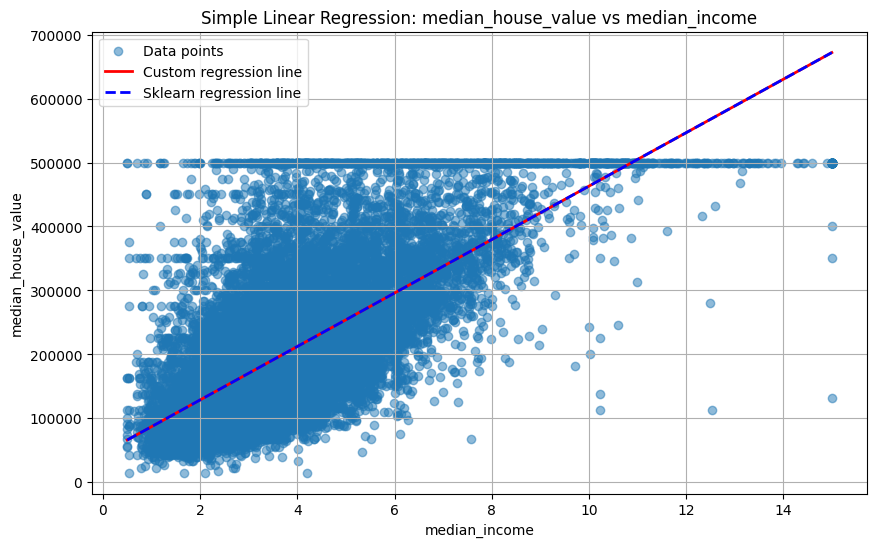

In [25]:
# Analysis for the first feature: median_income
slr1, sklearn_slr1 = analyze_simple_linear_regression('median_income')


=== Analysis for feature: 'total_rooms' ===
Feature stats - Mean: 2635.76, Std: 2181.62

Fitting custom model on normalized data...


  8%|▊         | 809/10000 [00:00<00:01, 6254.25it/s]

Converged after 809 iterations
Fitting sklearn model...

Custom Implementation Results (denormalized):
Intercept (beta_0): 188152.5006
Coefficient (beta_1): 7.0960

Sklearn Implementation Results:
Intercept (beta_0): 188152.5153
Coefficient (beta_1): 7.0960

Comparison of both implementations:
Parameter            Custom          Sklearn         Difference     
-----------------------------------------------------------------
Intercept (beta_0)   188152.5006     188152.5153     0.01470946     
Coefficient (beta_1) 7.0960          7.0960          0.00000056     


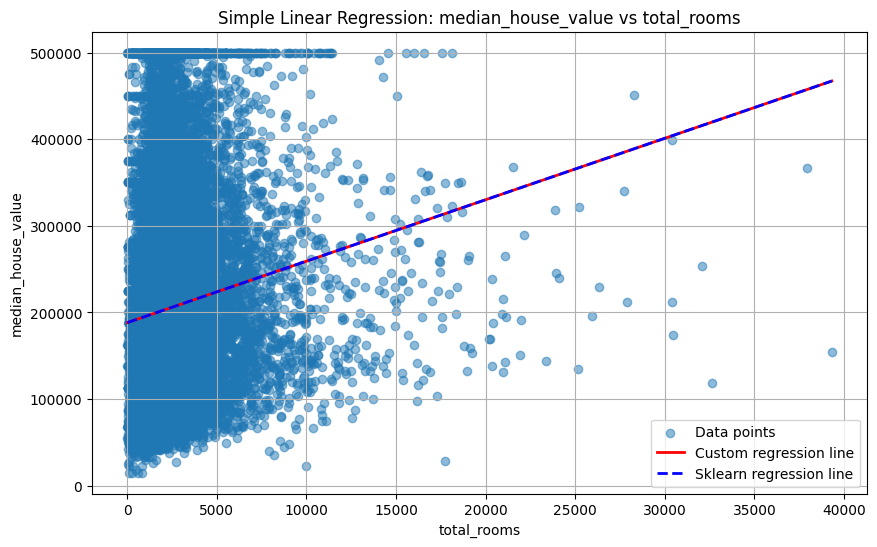

In [26]:
# Analysis for the second feature: total_rooms
slr2, sklearn_slr2 = analyze_simple_linear_regression('total_rooms')


=== Analysis for feature: 'housing_median_age' ===
Feature stats - Mean: 28.64, Std: 12.59

Fitting custom model on normalized data...


  8%|▊         | 809/10000 [00:00<00:01, 6853.26it/s]

Converged after 809 iterations
Fitting sklearn model...

Custom Implementation Results (denormalized):
Intercept (beta_0): 179119.9026
Coefficient (beta_1): 968.4496

Sklearn Implementation Results:
Intercept (beta_0): 179119.9166
Coefficient (beta_1): 968.4496

Comparison of both implementations:
Parameter            Custom          Sklearn         Difference     
-----------------------------------------------------------------
Intercept (beta_0)   179119.9026     179119.9166     0.01400268     
Coefficient (beta_1) 968.4496        968.4496        0.00007578     


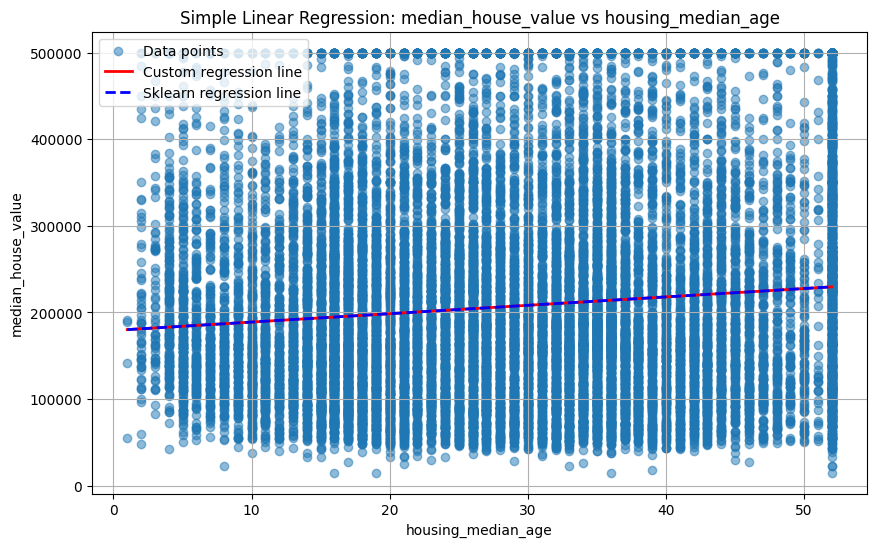

In [27]:
# Analysis for the third feature: housing_median_age
slr3, sklearn_slr3 = analyze_simple_linear_regression('housing_median_age')


=== Analysis for feature: 'population' ===
Feature stats - Mean: 1425.48, Std: 1132.46

Fitting custom model on normalized data...


  8%|▊         | 808/10000 [00:00<00:01, 8115.79it/s]

Converged after 808 iterations
Fitting sklearn model...

Custom Implementation Results (denormalized):
Intercept (beta_0): 210436.2453
Coefficient (beta_1): -2.5118

Sklearn Implementation Results:
Intercept (beta_0): 210436.2621
Coefficient (beta_1): -2.5118

Comparison of both implementations:
Parameter            Custom          Sklearn         Difference     
-----------------------------------------------------------------
Intercept (beta_0)   210436.2453     210436.2621     0.01678888     
Coefficient (beta_1) -2.5118         -2.5118         0.00000020     


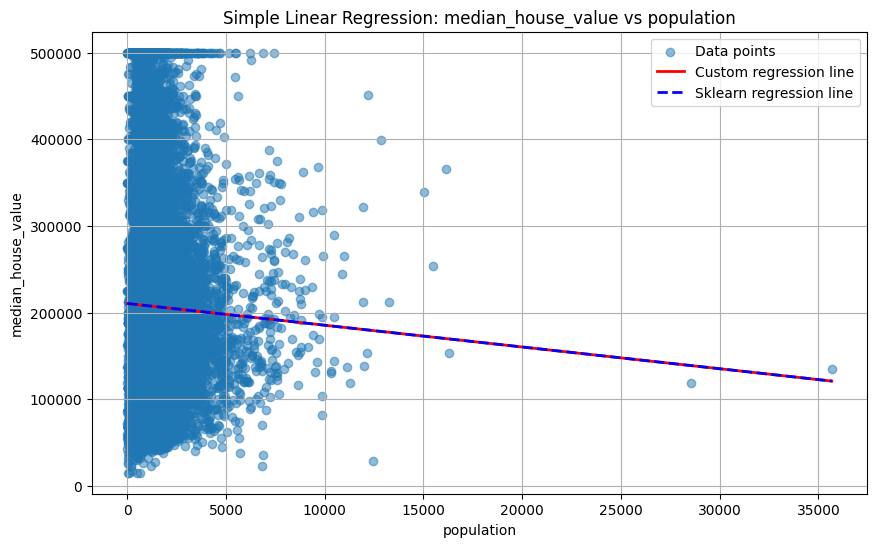

In [28]:
# Analysis for the fourth feature: population
slr4, sklearn_slr4 = analyze_simple_linear_regression('population')


=== Analysis for feature: 'households' ===
Feature stats - Mean: 499.54, Std: 382.33

Fitting custom model on normalized data...


  8%|▊         | 806/10000 [00:00<00:02, 3611.66it/s]



Converged after 806 iterations
Fitting sklearn model...

Custom Implementation Results (denormalized):
Intercept (beta_0): 196928.5608
Coefficient (beta_1): 19.8728

Sklearn Implementation Results:
Intercept (beta_0): 196928.5772
Coefficient (beta_1): 19.8728

Comparison of both implementations:
Parameter            Custom          Sklearn         Difference     
-----------------------------------------------------------------
Intercept (beta_0)   196928.5608     196928.5772     0.01635816     
Coefficient (beta_1) 19.8728         19.8728         0.00000165     


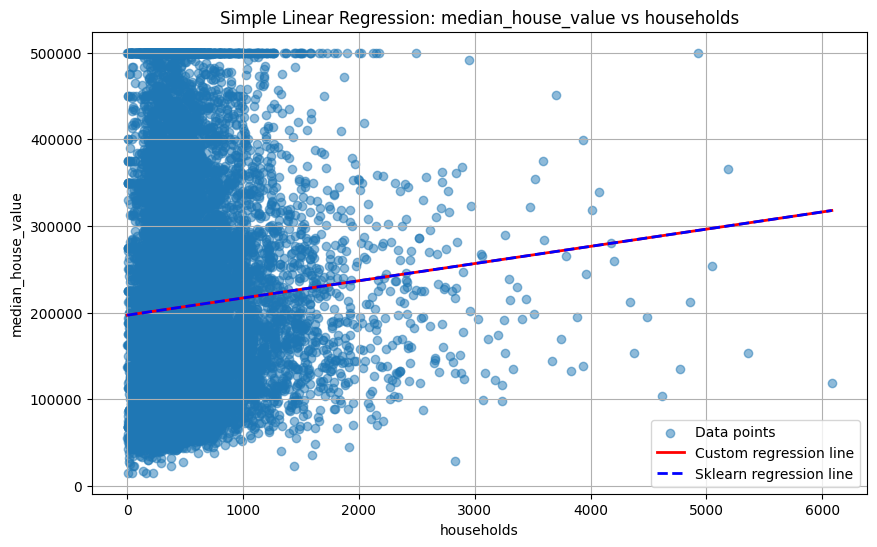

In [30]:
# Analysis for the fifth feature: total_bedrooms
slr5, sklearn_slr5 = analyze_simple_linear_regression('households')